<a href="https://colab.research.google.com/github/ssingh-rookie/tensorflow_nlp/blob/master/NLP_Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import json
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-04-05 14:51:10--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 2607:f8b0:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.07s   

2020-04-05 14:51:10 (81.3 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [0]:
with open('/tmp/sarcasm.json', 'r') as json_file:
  data = json.load(json_file)

In [6]:
data[0]

{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
 'is_sarcastic': 0}

In [0]:
headlines = []
labels = []
for article in data:
  h,l = article['headline'], article['is_sarcastic']
  headlines.append(h)
  labels.append(l)


In [27]:
print(headlines[:5])

["former versace store clerk sues over secret 'black code' for minority shoppers", "the 'roseanne' revival catches up to our thorny political mood, for better and worse", "mom starting to fear son's web series closest thing she will have to grandchild", 'boehner just wants wife to listen, not come up with alternative debt-reduction ideas', 'j.k. rowling wishes snape happy birthday in the most magical way']


#### Define parameters

In [0]:
vocab_size = 10000
max_len = 40
oov_token = "<OOV>"
pad_type = "post"
trunc_type = "post"
validation_ratio = 0.8
embedding_dim = 16

#### Define train and test splits

In [29]:
train_size = int(len(headlines) * validation_ratio)
print(train_size)

21367


In [30]:
train_data = headlines[:train_size]
train_labels = labels[:train_size]

test_data = headlines[train_size:]
test_labels = labels[train_size:]

print("Train data size ", len(train_data))
print("Test data size :", len(test_data))

Train data size  21367
Test data size : 5342


#### Tokenize the headlines

In [0]:
token = Tokenizer(vocab_size, oov_token=oov_token)
token.fit_on_texts(train_data)
word_index = token.word_index

train_seq = token.texts_to_sequences(train_data)
train_pad = pad_sequences(train_seq, padding=pad_type, truncating=trunc_type, maxlen=max_len)

test_seq = token.texts_to_sequences(test_data)
test_pad = pad_sequences(test_seq, padding=pad_type, truncating=trunc_type, maxlen=max_len)

train_labels_final = np.array(train_labels)
test_labels_final = np.array(test_labels)

In [37]:
print("Train data ", train_pad.shape)
print("Train data ", test_pad.shape)

Train data  (21367, 40)
Train data  (5342, 40)


#### Initialize model

In [0]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])

In [59]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 40, 16)            160000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


In [49]:
NO_EPOCHS = 10
history = model.fit(x=train_pad, y=train_labels_final, epochs=NO_EPOCHS, validation_data=(test_pad, test_labels_final))

Epoch 1/10
668/668 [==============================] - 18s 27ms/step - loss: 0.0469 - accuracy: 0.9842 - val_loss: 0.5856 - val_accuracy: 0.8428
Epoch 2/10
668/668 [==============================] - 19s 28ms/step - loss: 0.0311 - accuracy: 0.9907 - val_loss: 0.7388 - val_accuracy: 0.8328
Epoch 3/10
668/668 [==============================] - 19s 28ms/step - loss: 0.0235 - accuracy: 0.9927 - val_loss: 0.7631 - val_accuracy: 0.8375
Epoch 4/10
668/668 [==============================] - 19s 28ms/step - loss: 0.0164 - accuracy: 0.9951 - val_loss: 0.8542 - val_accuracy: 0.8411
Epoch 5/10
668/668 [==============================] - 19s 28ms/step - loss: 0.0142 - accuracy: 0.9956 - val_loss: 0.9328 - val_accuracy: 0.8381
Epoch 6/10
668/668 [==============================] - 19s 28ms/step - loss: 0.0123 - accuracy: 0.9961 - val_loss: 0.8978 - val_accuracy: 0.8334
Epoch 7/10
668/668 [==============================] - 19s 28ms/step - loss: 0.0084 - accuracy: 0.9977 - val_loss: 1.0320 - val_accuracy:

In [0]:
import matplotlib.pyplot as plt

def plot_model_results(history, string ):
  train = history.history[string]
  val = history.history['val_' + string]
  plt.plot(train)
  plt.plot(val)
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()

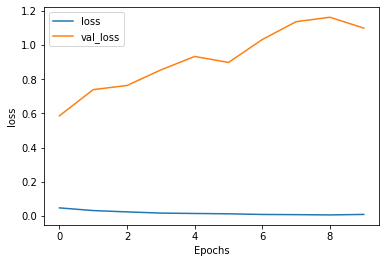

In [52]:
plot_model_results(history, 'loss')

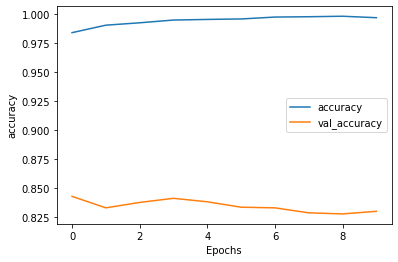

In [53]:
plot_model_results(history, 'accuracy')

#### Increasing model complexity

In [61]:
model_1 = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_len),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                             tf.keras.layers.Dense(6, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid')
])
                             
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 16)            160000    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 40, 64)            12544     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 390       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 197,773
Trainable params: 197,773
Non-trainable params: 0
_________________________________________________________________


In [63]:
NO_EPOCHS = 10
model_1_history = model_1.fit(x=train_pad, y=train_labels_final, epochs=NO_EPOCHS, validation_data=(test_pad, test_labels_final))

Epoch 1/10
668/668 [==============================] - 39s 58ms/step - loss: 0.4076 - accuracy: 0.8069 - val_loss: 0.3381 - val_accuracy: 0.8525
Epoch 2/10
668/668 [==============================] - 38s 56ms/step - loss: 0.2226 - accuracy: 0.9116 - val_loss: 0.3511 - val_accuracy: 0.8581
Epoch 3/10
668/668 [==============================] - 38s 57ms/step - loss: 0.1465 - accuracy: 0.9449 - val_loss: 0.3948 - val_accuracy: 0.8469
Epoch 4/10
668/668 [==============================] - 37s 56ms/step - loss: 0.0975 - accuracy: 0.9647 - val_loss: 0.5092 - val_accuracy: 0.8420
Epoch 5/10
668/668 [==============================] - 38s 56ms/step - loss: 0.0619 - accuracy: 0.9789 - val_loss: 0.5788 - val_accuracy: 0.8375
Epoch 6/10
668/668 [==============================] - 38s 56ms/step - loss: 0.0397 - accuracy: 0.9872 - val_loss: 0.6577 - val_accuracy: 0.8371
Epoch 7/10
668/668 [==============================] - 37s 56ms/step - loss: 0.0291 - accuracy: 0.9905 - val_loss: 0.7586 - val_accuracy:

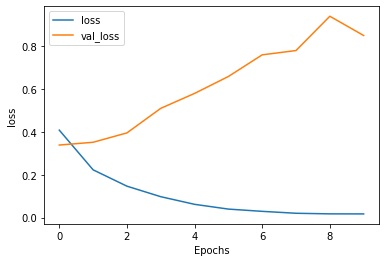

In [64]:
plot_model_results(model_1_history, 'loss')

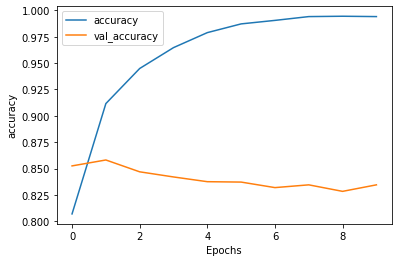

In [65]:
plot_model_results(model_1_history, 'accuracy')

In [67]:
!git remote add origin https://github.com/ssingh-rookie/tensorflow_nlp.git

fatal: remote origin already exists.
